# Análisis de relación entre población y empleo

## Importing libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import esda
import pysal
import libpysal as lps
from splot import esda as esdaplot


module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-02-20 18:10:41 Configured OSMnx 1.1.1
2023-02-20 18:10:41 HTTP response caching is on


## Downloading data

Hexres 9

(6003, 433)


<AxesSubplot:>

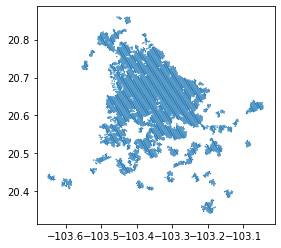

In [22]:
city = 'Guadalajara'
schema = 'censo'
folder = 'censo_10_20_hexres9'
query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" LIKE \'{city}\'"
hex_censo_9 = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_censo_9.shape)
hex_censo_9.plot()

In [23]:
fields_to_keep = ['hex_id_9','10_pobtot','city','geometry']
hex_censo_9 = hex_censo_9[fields_to_keep]
hex_censo_9.head()

,hex_id_9,10_pobtot,city,geometry
0,8949ab49dd3ffff,769.0,Guadalajara,"POLYGON ((-103.44558 20.81956, -103.44436 20.8..."
1,8949aa25017ffff,1096.0,Guadalajara,"POLYGON ((-103.42468 20.45386, -103.42346 20.4..."
2,89498c96ddbffff,607.0,Guadalajara,"POLYGON ((-103.39147 20.66055, -103.39026 20.6..."
3,8949aa251abffff,959.0,Guadalajara,"POLYGON ((-103.44849 20.46954, -103.44727 20.4..."
4,89498c94ed7ffff,1700.0,Guadalajara,"POLYGON ((-103.32570 20.71522, -103.32448 20.7..."


DENUE

In [24]:
gdf_tmp = hex_censo_9.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry('geometry')
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [25]:
schema = 'denue'
folder = 'denue_2010'

query = f'SELECT * FROM {schema}.{folder} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')'
denue = aup.gdf_from_query(query, geometry_col='geometry')
# hex_censo = odc.gdf_from_db('censo1020_mza_hexres9_buffer2km','segundopiso')
print(denue.shape)
denue.head(2)

(180612, 32)


,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,nom_vial,numero_ext,edificio,numero_int,nomb_asent,...,latitud,longitud,geometry,index_right,cve_ent,cve_mun,nom_mun,oid,cvegeo,id
0,INDUSTRIA DE ALUMBRADO Y HERRAJE,INDUSTRIA DE ALUMBRADO Y HERRAJE SA DE CV,332999,FABRICACION DE OTROS PRODUCTOS METALICOS,101 A 250 PERSONAS,None,1980,None,301,GRANJA SAN MATEO,...,20.439167,-103.237778,POINT (-103.23778 20.43917),424,14,044,Ixtlahuacán de los Membrillos,425,14044,1616683
1,ABARROTES,None,461110,"COMERCIO AL POR MENOR EN TIENDAS DE ABARROTES,...",0 A 5 PERSONAS,CUAUHTEMOC,52C,None,None,CAJITITLAN,...,20.435157,-103.311285,POINT (-103.31128 20.43516),465,14,097,Tlajomulco de Zúñiga,466,14097,1702953


## Calculating average number of jobs per economic unit

In [26]:
denue.per_ocu.unique()

array(['101 A 250 PERSONAS', '0 A 5 PERSONAS', '6 A 10 PERSONAS',
       '11 A 30 PERSONAS', '251 Y MAS PERSONAS', '51 A 100 PERSONAS',
       'NO ESPECIFICADO', '31 A 50 PERSONAS'], dtype=object)

In [27]:
def number_of_jobs(per_ocu):
    jobs_dict = {'NO ESPECIFICADO':0,
                '0 A 5 PERSONAS':3,
                '6 A 10 PERSONAS':8,
                '11 A 30 PERSONAS':20,
                '31 A 50 PERSONAS':40,
                '51 A 100 PERSONAS':75,
                '101 A 250 PERSONAS':175,
                '251 Y MAS PERSONAS':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [28]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

## Spatial join

In [29]:
# Duda para después, ¿.overlay le pasa la información de hex a los puntos?

In [30]:
denue_hex9 = denue.overlay(hex_censo_9)
print(denue_hex9.shape)
denue_hex9.head(2)

(180543, 36)


,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,nom_vial,numero_ext,edificio,numero_int,nomb_asent,...,cve_mun,nom_mun,oid,cvegeo,id,per_ocu_num,hex_id_9,10_pobtot,city,geometry
0,INDUSTRIA DE ALUMBRADO Y HERRAJE,INDUSTRIA DE ALUMBRADO Y HERRAJE SA DE CV,332999,FABRICACION DE OTROS PRODUCTOS METALICOS,101 A 250 PERSONAS,None,1980,None,301,GRANJA SAN MATEO,...,044,Ixtlahuacán de los Membrillos,425,14044,1616683,175,8949aa2ab53ffff,1066.0,Guadalajara,POINT (-103.23778 20.43917)
1,ABARROTES,None,461110,"COMERCIO AL POR MENOR EN TIENDAS DE ABARROTES,...",0 A 5 PERSONAS,CUAUHTEMOC,52C,None,None,CAJITITLAN,...,097,Tlajomulco de Zúñiga,466,14097,1702953,3,8949aa21b1bffff,1246.0,Guadalajara,POINT (-103.31128 20.43516)


Agrupar por hexágono, contar los puntos

In [31]:
denue_hex9_res = denue_hex9.groupby('hex_id_9').count()
denue_hex9_res = denue_hex9_res.reset_index().rename(columns={'id':'denue_count'})
denue_hex9_res = denue_hex9_res[['hex_id_9','denue_count']].copy()
print(denue_hex9_res.shape)
denue_hex9_res.head(2)

(4293, 2)


,hex_id_9,denue_count
0,89498c86483ffff,2
1,89498c86487ffff,12


Unir con la capa de DENUE, sumando el numero de empleos

In [32]:
denue_hex9_res = denue_hex9_res.merge(denue_hex9.groupby('hex_id_9').sum().reset_index()[['hex_id_9','per_ocu_num']],
                     on='hex_id_9')
print(denue_hex9_res.shape)
denue_hex9_res.head(2)

(4293, 3)


,hex_id_9,denue_count,per_ocu_num
0,89498c86483ffff,2,23
1,89498c86487ffff,12,95


Unir con la capa del CENSO, en donde está la pobtot y la geometría por hexágono

In [33]:
hex_empleo_9 = hex_censo_9.merge(denue_hex9_res, on='hex_id_9', how='left')
print(hex_empleo_9.shape)
hex_empleo_9.head(2)

(6003, 6)


,hex_id_9,10_pobtot,city,geometry,denue_count,per_ocu_num
0,8949ab49dd3ffff,769.0,Guadalajara,"POLYGON ((-103.44558 20.81956, -103.44436 20.8...",NaN,NaN
1,8949aa25017ffff,1096.0,Guadalajara,"POLYGON ((-103.42468 20.45386, -103.42346 20.4...",4.0,12.0


Cambiar NANs

In [34]:
idx = hex_empleo_9.denue_count.isna()
hex_empleo_9.loc[idx,['denue_count','per_ocu_num']] = 0.1,0.1

## Relación población_empleo

In [35]:
hex_empleo_9['pob_denue'] = hex_empleo_9['10_pobtot'] / hex_empleo_9['per_ocu_num']

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


<AxesSubplot:>

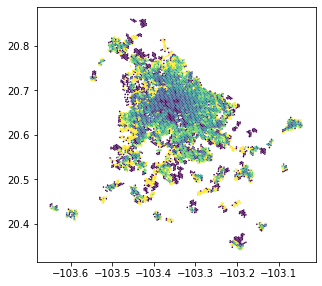

In [36]:
fig,ax = plt.subplots(figsize=(5,5))
hex_empleo_9.plot('pob_denue', scheme='quantiles',ax=ax)

<AxesSubplot:xlabel='pob_denue', ylabel='Count'>

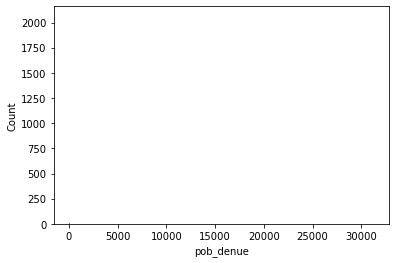

In [37]:
sns.histplot(hex_empleo_9['pob_denue'])

<AxesSubplot:xlabel='log_pob_denue', ylabel='Count'>

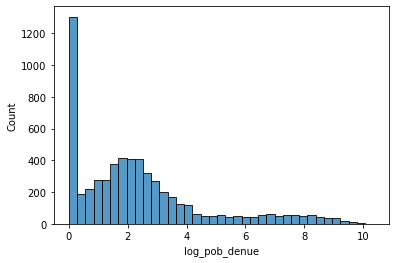

In [38]:
hex_empleo_9['pob_denue_p1'] = hex_empleo_9['pob_denue'] + 1
hex_empleo_9['log_pob_denue'] = np.log(hex_empleo_9['pob_denue_p1'])
sns.histplot(hex_empleo_9['log_pob_denue'])

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


<AxesSubplot:>

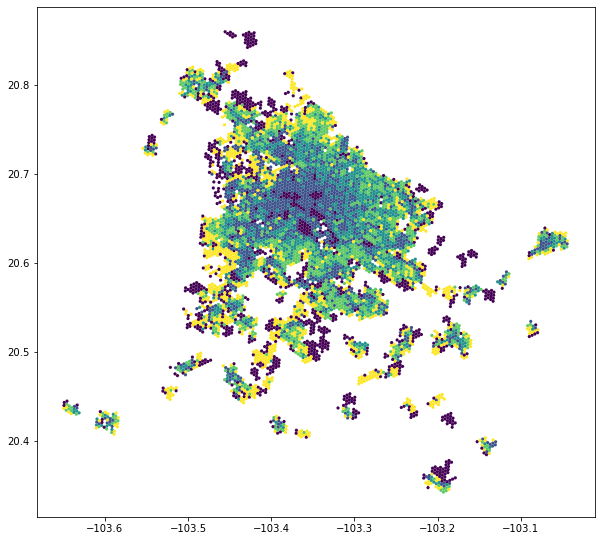

In [39]:
fig,ax = plt.subplots(figsize=(10,10))
hex_empleo_9.plot('log_pob_denue', scheme='quantiles',ax=ax)

In [40]:
hex_empleo_9.head(1)

,hex_id_9,10_pobtot,city,geometry,denue_count,per_ocu_num,pob_denue,pob_denue_p1,log_pob_denue
0,8949ab49dd3ffff,769.0,Guadalajara,"POLYGON ((-103.44558 20.81956, -103.44436 20.8...",0.1,0.1,7690.0,7691.0,8.947806


## Saving to db

In [41]:
aup.gdf_to_db_slow(hex_empleo_9,'acceso_empleo2010_amg_hexres9','segundopiso',if_exists="replace")